<a href="https://colab.research.google.com/github/NicolasNgo/QRSDetection/blob/main/QRSdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QRS detection on ECG signals from Paroxysmal Atrial Fibrillation prediction challenge database



## wfdb library installation

May require to restart the environment

In [48]:
!pip install wfdb

# Python code to apply the Pan-Tompkins QRS detection algorithm

In [4]:
# Importation of the libraries
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from itertools import zip_longest


# Preprocessing methods
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed 
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds. 

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()
	
    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12] 
	
    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*128)/8

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result    

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * 128)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum
    
    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):  
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned. 
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    global der
    der = self.derivative(bpass.copy())

    # Squaring Function
    global sqr
    sqr = self.squaring(der.copy())

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqr.copy())

    return mwin

# Importing Libraries
from scipy import signal as sg



### R peaks detection
class heart_rate():

  def __init__(self,signal,samp_freq):
    '''
    Initialize Variables
    :param signal: input signal
    :param samp_freq: sample frequency of input signal
    '''

    # Initialize variables
    self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
    self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

    self.T_wave = False          
    self.m_win = mwin
    self.b_pass = bpass
    self.samp_freq = samp_freq
    self.signal = signal
    self.win_150ms = round(0.15*self.samp_freq)

    self.RR_Low_Limit = 0
    self.RR_High_Limit = 0
    self.RR_Missed_Limit = 0
    self.RR_Average1 = 0


  def approx_peak(self):
    '''
    Approximate peak locations
    '''   

    # FFT convolution
    slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

    # Finding approximate peak locations
    for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            self.peaks.append(i)  


  def adjust_rr_interval(self,ind):
    '''
    Adjust RR Interval and Limits
    :param ind: current index in peaks array
    '''

    # Finding the eight most recent RR intervals
    self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.samp_freq   

    # Calculating RR Averages
    self.RR_Average1 = np.mean(self.RR1)
    RR_Average2 = self.RR_Average1
      
    # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
    if (ind >= 8):
        for i in range(0, 8):
            if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                self.RR2.append(self.RR1[i])

                if (len(self.RR2) > 8):
                    self.RR2.remove(self.RR2[0])
                    RR_Average2 = np.mean(self.RR2)    

    # Adjusting the RR Low Limit and RR High Limit
    if (len(self.RR2) > 7 or ind < 8):
        self.RR_Low_Limit = 0.92 * RR_Average2        
        self.RR_High_Limit = 1.16 * RR_Average2
        self.RR_Missed_Limit = 1.66 * RR_Average2


  def searchback(self,peak_val,RRn,sb_win):
      '''
      Searchback
      :param peak_val: peak location in consideration
      :param RRn: the most recent RR interval
      :param sb_win: searchback window
      '''

      # Check if the most recent RR interval is greater than the RR Missed Limit
      if (RRn > self.RR_Missed_Limit):
          # Initialize a window to searchback  
          win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

          # Find the x locations inside the window having y values greater than Threshold I1             
          coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

          # Find the x location of the max peak value in the search window
          if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      x_max = pos
                      break
          else:
            x_max = None
 
          # If the max peak value is found
          if (x_max is not None):   
            # Update the thresholds corresponding to moving window integration
            self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
            self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
            self.Threshold_I2 = 0.5 * self.Threshold_I1         

            # Initialize a window to searchback 
            win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

            # Find the x locations inside the window having y values greater than Threshold F1                   
            coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      r_max = pos
                      break
            else:
              r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:                                                        
                  self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                  self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                  self.Threshold_F2 = 0.5 * self.Threshold_F1      

                  # Append the probable R peak location                      
                  self.r_locs.append(r_max)                                                


  def find_t_wave(self,peak_val,RRn,ind,prev_ind):
    '''
    T Wave Identification
    :param peak_val: peak location in consideration
    :param RRn: the most recent RR interval
    :param ind: current index in peaks array
    :param prev_ind: previous index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        if (ind > 0 and 0.20 < RRn < 0.36):
          # Find the slope of current and last waveform detected        
          curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
          last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
          
          # If current waveform slope is less than half of last waveform slope
          if (curr_slope < 0.5*last_slope):  
              # T Wave is found and update noise threshold                      
              self.T_wave = True                             
              self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

        if (not self.T_wave):
            # T Wave is not found and update signal thresholds
            if (self.probable_peaks[ind] > self.Threshold_F1):   
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

    # Update noise thresholds
    elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def adjust_thresholds(self,peak_val,ind):
    '''
    Adjust Noise and Signal Thresholds During Learning Phase
    :param peak_val: peak location in consideration
    :param ind: current index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        # Update signal threshold
        self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

        if (self.probable_peaks[ind] > self.Threshold_F1):                                            
            self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

            # Append the probable R peak location
            self.r_locs.append(self.probable_peaks[ind])  

        else:
            # Update noise threshold
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
        
    # Update noise thresholds    
    elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def update_thresholds(self):
    '''
    Update Noise and Signal Thresholds for next iteration
    '''

    self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
    self.Threshold_I2 = 0.5 * self.Threshold_I1 
    self.Threshold_F2 = 0.5 * self.Threshold_F1
    self.T_wave = False 


  def ecg_searchback(self):
    '''
    Searchback in ECG signal to increase efficiency
    '''

    # Filter the unique R peak locations
    self.r_locs = np.unique(np.array(self.r_locs).astype(int))

    # Initialize a window to searchback
    win_200ms = round(0.2*self.samp_freq)
   
    for r_val in self.r_locs:
        coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

        # Find the x location of the max peak value
        if (len(coord) > 0):
          for pos in coord:
              if (self.signal[pos] == max(self.signal[coord])):
                  x_max = pos
                  break
        else:
          x_max = None

        # Append the peak location
        if (x_max is not None):   
          self.result.append(x_max)


  def find_r_peaks(self):
    '''
    R Peak Detection
    '''

    # Find approximate peak locations
    self.approx_peak()

    # Iterate over possible peak locations
    for ind in range(len(self.peaks)):

        # Initialize the search window for peak detection
        peak_val = self.peaks[ind]
        win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
        max_val = max(self.b_pass[win_300ms], default = 0)

        # Find the x location of the max peak value
        if (max_val != 0):        
          x_coord = np.asarray(self.b_pass == max_val).nonzero()
          self.probable_peaks.append(x_coord[0][0])
        
        if (ind < len(self.probable_peaks) and ind != 0):
            # Adjust RR interval and limits
            self.adjust_rr_interval(ind)
            
            # Adjust thresholds in case of irregular beats
            if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                self.Threshold_I1 /= 2
                self.Threshold_F1 /= 2

            RRn = self.RR1[-1]

            # Searchback
            self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

            # T Wave Identification
            self.find_t_wave(peak_val,RRn,ind,ind-1)

        else:
          # Adjust threholds
          self.adjust_thresholds(peak_val,ind)

        # Update threholds for next iteration
        self.update_thresholds()

    # Searchback in ECG signal 
    self.ecg_searchback()

    return self.result

# R peaks detection function

In [5]:
def r_peaks(signal_name, start_of_the_sample, end_of_the_sample):
  '''
  R peaks detection
  :param signal_name: name of the signal in the PhysioNet database to be treated
  :param start_of_the_sample: Time in sec of the begining of the sample
  :param end_of_the_sample: Time in sec of the end of the sample
  :return: R peaks locations
  '''

  # Transformation of the date of start and end of the sample into sample numbers
  fs = 128

  if(end_of_the_sample is None):
    end = None
  else:
    end = end_of_the_sample*fs
  
  if(start_of_the_sample is None):
    start = None
  else:
    start = start_of_the_sample*fs

  # Importation of the signal
  print('Upload file')
  record = wfdb.rdrecord(signal_name, pn_dir = 'afpdb/1.0.0/', sampfrom = start, sampto = end)
  annotation = wfdb.rdann(signal_name, pn_dir = 'afpdb/1.0.0/', extension = 'qrs', sampfrom = start, sampto = end, shift_samps = True)
  # record = wfdb.rdrecord(signal_name, pn_dir = 'afpdb/1.0.0/')
  # annotation = wfdb.rdann(signal_name, pn_dir = 'afpdb/1.0.0/', extension = 'qrs', shift_samps = True)

  # Preprocessing steps
  QRS_detector = Pan_Tompkins_QRS()
  ecg = pd.DataFrame(np.array([list(range(len(record.p_signal))), record.p_signal[:,0]]).T, columns = ['TimeStamp', 'ecg'])
  print('Preprocessing')
  output_signal = QRS_detector.solve(ecg)

  # Convert ecg signal to numpy array
  signal = ecg.iloc[:,1].to_numpy()

  # Find the R peaks location
  print('QRS detection')
  hr = heart_rate(signal, annotation.fs)
  result = hr.find_r_peaks()
  result = np.array(result)

  # Clip the x locations less than 0 (Learning Phase)
  result = result[result > 0]

  # Computation of the RR intervals
  data = {'RR_ECG0':np.diff(result[1:]/annotation.fs), 'R_location_0':result[1:]}
  df = pd.concat([pd.DataFrame(v, columns = [k]) for k, v in data.items()], axis = 1)
  zl = list(zip_longest(*data.values()))
  results = pd.DataFrame(zl, columns = data.keys())

  return results

# Comparison R peaks detection between PhysioNet et QRS detection algorithm Pan-Tompkins

### RR estimation from annotation file

In [6]:
def ann2rr(record_name,
           extension,
           pn_dir = None, 
           start_time = None, 
           stop_time = None, 
           format = None, 
           as_array = True):

  from wfdb.processing import hr
  from wfdb.io import record
  import posixpath
  """
  Obtain RR interval series from ECG annotation files.

  Parameters
  ----------
  record_name: str
    the record name of the WFDB annotation file. ie. for file '100.atr'n
    record_name = '100'.
  extension : str
    The annotator extension of the annotation file. ie. for file '100.atr', extension = 'atr'.
  pn_dir : str, optional
    Option used to stream data from Physionet. The PhysioNet database
    directory from which to find the required annotation file. eg. For
    record '100' in 'http://physionet.org/content/mitdb': pn_dir='mitdb'.
  start_time : float, optional
    The time to start the intervals in seconds.
  stop_time : float, optional
    The time to stop the intervals in seconds.
  format : str, optional
    Print intervals in the specified format. By default, intervals are
    printed in units of sample intervals. Other formats include
    's' (seconds), 'm' (minutes), 'h' (hours). Set to 'None' for samples.
  as_array : bool, optional
    If True, return an an 'ndarray', else print the output.
  Returns
  -------
  N/A
  """

  if (pn_dir is not None) and ("." not in pn_dir):
      dir_list = pn_dir.split("/")
      pn_dir = posixpath.join(
          dir_list[0], record.get_version(dir_list[0]), *dir_list[1:]
      )

  ann = wfdb.rdann(record_name, extension, pn_dir=pn_dir)

  rr_interval = hr.calc_rr(ann.sample, fs=ann.fs)
  rr_interval = np.insert(rr_interval, 0, ann.sample[0])

  time_interval = rr_interval / ann.fs
  if start_time is not None:
      time_interval = time_interval[(time_interval.cumsum() > start_time).astype(bool)]
  if stop_time is not None:
      time_interval = time_interval[(time_interval.cumsum() < stop_time).astype(bool)]

  # Already given in seconds (format == 's')
  if format == "s":
      out_interval = time_interval
  elif format == "m":
      out_interval = time_interval / 60
  elif format == "h":
      out_interval = time_interval / (60 * 60)
  else:
      out_interval = np.around(time_interval * ann.fs).astype(np.int)

  if as_array:
      return out_interval
  else:
      print(*out_interval, sep="\n")


### Plot the R peak location for the Pan-Tompkins and PhysioNet QRS detector

In [7]:
def comparison(signal_name, start_of_the_sample, end_of_the_sample):
  '''
  The function will plot and returns the R peaks detected by Pan-Tompkins algorithm and handed by the PhysioNet database
  between the two time slot given in the parameters. 
  :param signal_name: the name of the signal file in PhysioNet database
  :param start_of_the_sample: the beginning of sample in seconds
  :param end_of_the_sample: the end of the sample in seconds
  '''

  # Computation of the rr intervals (and r peak location) regarding to the Pan-Tompkins algorithm
  rr_pan_tompkins = r_peaks(signal_name = signal_name, start_of_the_sample = start_of_the_sample, end_of_the_sample = end_of_the_sample)
  location = rr_pan_tompkins.R_location_0

  # Loading the 'raw' ECG signal between the two time slots
  annotation = wfdb.rdann(signal_name, extension = 'qrs', pn_dir = 'afpdb/1.0.0/')
  start = start_of_the_sample*annotation.fs
  end = end_of_the_sample*annotation.fs

  record = wfdb.rdrecord(record_name = signal_name, sampfrom = start, sampto = end, pn_dir = 'afpdb/1.0.0/')
  annotation = wfdb.rdann(record_name = signal_name, sampfrom = start, sampto = end, pn_dir = 'afpdb/1.0.0/', extension = "qrs", shift_samps = True)

  signal = record.p_signal[:,0]
  plt.figure(figsize = (20, 4), dpi = 200)
  plt.xticks(np.arange(0, len(signal)+1, 5*annotation.fs), labels = [str(k // 60) + ':' + str(k%60) for k in np.arange(start_of_the_sample, end_of_the_sample + 5, 5)])
  plt.plot(signal)
  plt.scatter(location, signal[location], color = 'black', s = 50, marker = '*')
  plt.scatter(annotation.sample, signal[annotation.sample], color = 'red', s = 50, marker = 'x')

  plt.xlabel('Time (min)')
  plt.title('R peak locations')


In [47]:
def plot_rr(record_name, start_of_plot = 0, end_of_plot = None):
  '''
  Function to plot the two RR intervals estimated by each method.
  ------
  Parameters
  recordname: The name of the signal to plot 
  start: The begining time (in sec) of the desired time range
  end: The ending time (in sec) of the desired time range
  ------
  return
  A plot
  '''

  if(end_of_plot is None):
    end = None
  else:
    end = end_of_plot*128

  if(start_of_plot is None):
    start = None
  else:
    start = start_of_plot*128

  record = wfdb.rdrecord(record_name, pn_dir = 'afpdb/1.0.0/', sampfrom = start, sampto = end)
  annotation = wfdb.rdann(record_name, extension = 'qrs', pn_dir = 'afpdb/1.0.0/', sampfrom = start, sampto = end)

  signal = record.p_signal[:,0]
  rr = r_peaks(record_name, start_of_the_sample = start_of_plot, end_of_the_sample = end_of_plot)
  rr_pn = ann2rr(record_name, format = 's', pn_dir = 'afpdb/1.0.0/', extension = 'qrs', start_time = start_of_plot, stop_time = end_of_plot)

  plt.figure(figsize = (20, 4), dpi = 200)
  plt.xticks(np.arange(0, len(rr.RR_ECG0)+1, 60), labels = np.arange(0, len(rr.RR_ECG0)+1, 60)/60)
  plt.plot(rr['RR_ECG0'].cumsum(), rr['RR_ECG0'], marker = 'o', color = 'black', linewidth = 0.5, markersize = 2)
  plt.plot(rr_pn.cumsum(), rr_pn, marker = '.', color = 'red', linewidth = 0.5, markersize = 2)
  plt.xlabel('Time')
  plt.title('RR intervals for '+ record_name)


# Signal interactive look


In [79]:
def interactive_plot(record_name, start_of_the_plot, end_of_the_plot):
  # Import librairies
  from pandas.errors import InvalidIndexError
  import wfdb
  import pandas as pd
  import numpy as np
  from plotly import __version__
  %matplotlib inline

  import plotly.offline as pyo
  import plotly.graph_objs as go
  from plotly.offline import iplot

  import cufflinks as cf
  from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

  cf.go_offline()

  # Configure the widget
  def configure_plotly_browser_state():
    import IPython

    display(IPython.core.display.HTML('''
      <script src="/static/components/requirejs/require.js"></script>
      <script>
        requirejs.config({
          paths: {
            base:'/static/base',
            plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
          },
        });
        </script>
    '''))

  # Create the dataframe

  if(end_of_the_plot is None):
    end = None
  else:
    end = end_of_the_plot*128

  if(start_of_the_plot is None):
    start = None
  else:
    start = start_of_the_plot*128
    
  record = wfdb.rdrecord(record_name, pn_dir = 'afpdb/1.0.0/', sampfrom = start, sampto = end)
  df = pd.DataFrame({'Sample':[k for k in range(1, len(record.p_signal[:,0])+1)] ,'ECG0':record.p_signal[:,0], 'ECG1':record.p_signal[:,1], 'Time':[ str(int(((k+start)/128)//60)) + ':' + str(((k+start)/128)%60) for k in range(1, len(record.p_signal[:,0])+1)]})

  configure_plotly_browser_state()
  df.iplot(kind = 'line', x = 'Time', y = 'ECG0', color = 'blue', theme = 'solar', mode = 'lines')
  plt.show()

# Application

We're looking for samples of the records to identify the R peaks and the onset of AF. The availables files are name regarding whether it is NSR or pre-AF record. For 'p' prefixed files, those are the files corresponding to the patients with AF; each patient has a pair of record files. The first one, odd-named file is a NSR 30-min long record at any time of the screening and with no AF episode before and after it. The even-numbered files are the recordings of the 30 minutes before the onset of an AF episode. 

This means that odd-numbered files should not have AF in it
even-numbered files may have AF episode at the very end of the file. 

To describe the heart rhythm of the patients, the RR interval can be estimated from the ECG signal extracted from these patients. In order to estimate the RR intervals we have to first apply a QRS detector or at least to process the 'raw' ECG signal. 

PhysioNet provided a, already estimated series of RR intervals for each file/record. But this time series is not audited. We try to apply a QRS detector to the files that contains only the 'raw' ECG signals, we used the Pan-Tompkins QRS detector algorythm, this lead to 2 differents sets of RR interval for the same ECG recording. 

The question is then, for a handful numbers of signals, which method is the most appropriate with regards to the ECG. We also plotted the RR intervals estimated by the two methods in order to see the time range where the RR intervals estimation differ.

## Visualize the ECG + R peak location

To visualize the ECG signal and the R peak location regarding the two methods we use the *comparison(signal_name, start_of_the_sample, end_of_the_sample)* function implemented at the beginning of the document. 

The first argument *signal_name* is the name of the file in the PhysioNet database, as seen in the above section, with 'p' as a prefix. 

The second and third argument *start_of_the_sample* and *end_of_the_sample* are here to define the time range that should be considered. The two time has to be in seconds.

The function will return a graphic with the ECG recording in the defined time range and R peak location from the 2 algorithms. Black stars are the R peaks detected with the Pan-Tompkins algorithm and the red crosses are the R peaks given by PhysioNet. 


```
comparison(signal_name = 'p20', start_of_the_sample = 18*60, end_of_the_sample = 20*60)

```

The *plot_rr* function will plot the RR intervals estimated by the Pan-Tompkins algorithm and by the PhysioNet functions. 



```
plot_rr(record_name = 'p20', start_of_plot = 18*60, end_of_plot = 20*60) 
```

Finally the last usable function is *interactive_plot()* with plotly library which allows us to plot the interactive ECG signal from PhysioNet and eventually point at some specific point in the signal

```
interactive_pot(record_name = 'p20', start_of_the_plot = 18*60, end_of_the_plot = 20*60)
```



Upload file
Preprocessing
QRS detection


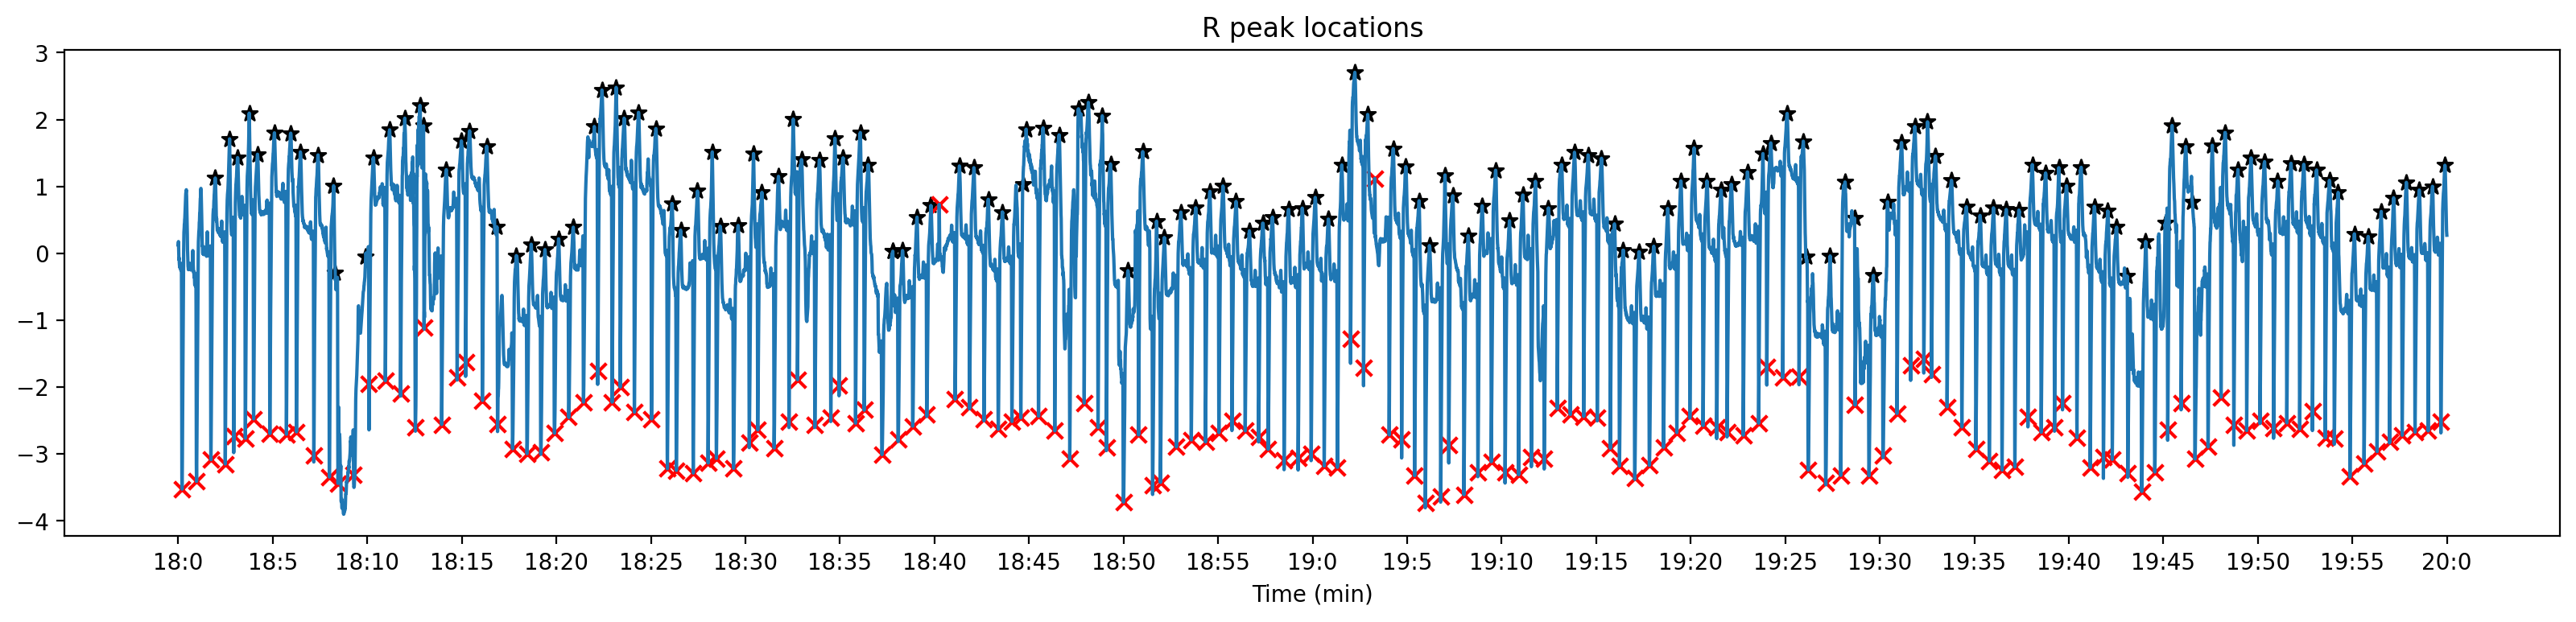

In [74]:
# Comparaison pour le signal p20 entre 18 et 20 minutes
comparison(signal_name = 'p20', start_of_the_sample = 18*60, end_of_the_sample = 20*60)

Upload file
Preprocessing
QRS detection


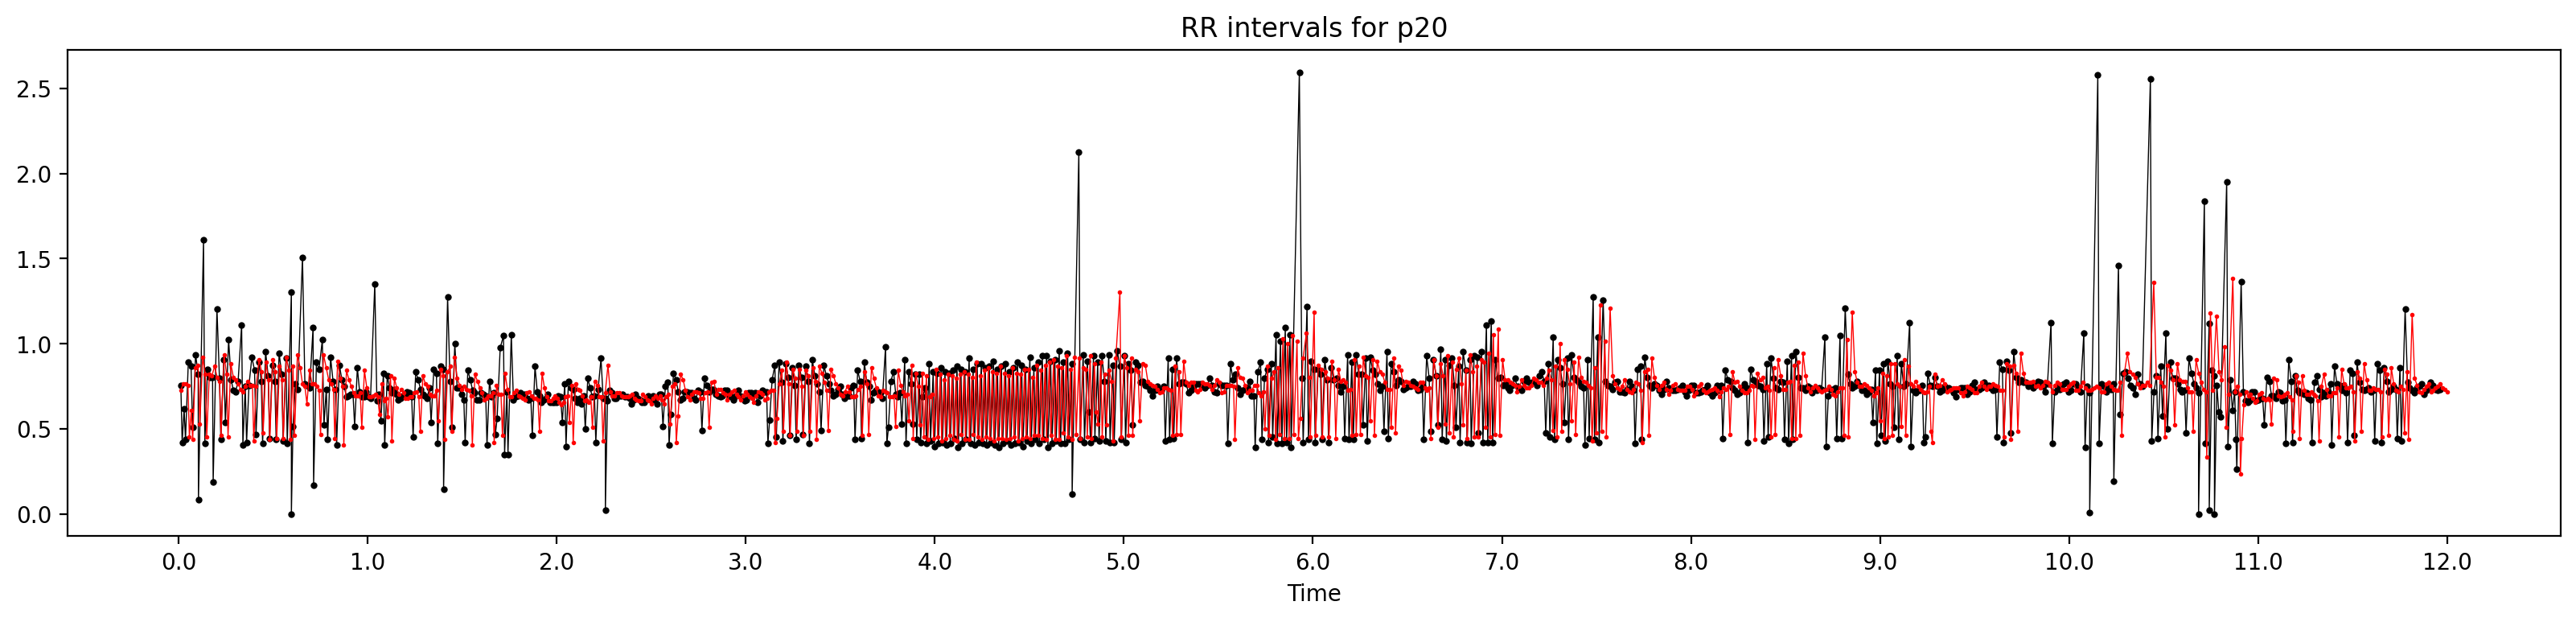

In [75]:
# RR intervals with the two methods
plot_rr('p20', start_of_plot = 18*60)

## Interactive plot of the ECG signal

In [80]:
interactive_plot(record_name='p20', start_of_the_plot=18*60, end_of_the_plot = 20*60)